In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage import io
import numpy as np
import glob
from PIL import Image

In [2]:
# get files list
files = (glob.glob('Coll*/data/*/*/*/Pr*/*rec.tif'))

In [3]:
# get all image arrays
Xs = []
for file in files:
    im = io.imread(file)
    Xs.append(im)

In [4]:
# size of image to work with
size = 60

# get the total number of images available
total_images = 0
for i in Xs:
    total_images+=len(i)

# data array
X = np.zeros(shape=(total_images,size,size))
idx = 0

# go over all images, scale them and pad with black space if needed 
for i in range(len(Xs)):
    for j in range(50,len(Xs[i])-50):
        img = Image.fromarray(Xs[i][j])
        img.thumbnail((size,size),Image.ANTIALIAS)
        img = np.asarray(img)
        pad = 0
        ax = 0
        if (img.shape[0]<size):
            pad = size-img.shape[0]
            pad = (np.zeros((pad//2,img.shape[1])), np.zeros((pad-pad//2,img.shape[1])))
            img = np.concatenate((pad[0],img,pad[1]),axis=0)
        elif (img.shape[1]<size):
            pad = size-img.shape[1]
            pad = (np.zeros((img.shape[0],pad//2)), np.zeros((img.shape[0],pad-pad//2)))
            img = np.concatenate((pad[0],img,pad[1]),axis=1)
        X[idx] = img
        idx+=1
X.shape     

(7871, 60, 60)

In [5]:
# normalize data
X2 = (X-X.min())/(X.max()-X.min())

0.1745905195362399 1.0 0.0


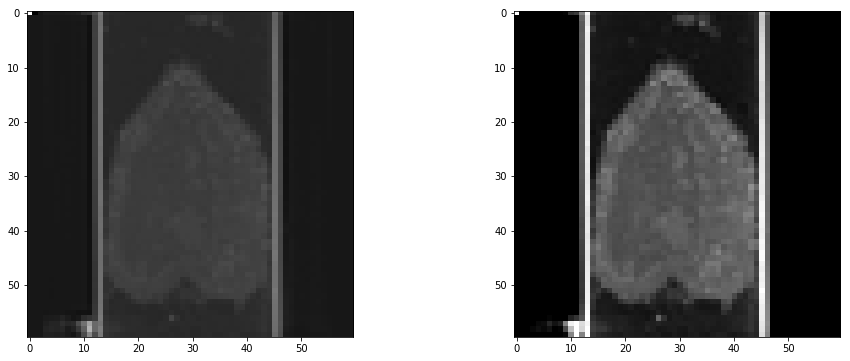

In [8]:
fig,ax = plt.subplots(ncols=2,figsize=(16,6))


# check some images at random
idx = np.random.randint(len(X2))
x = X2[idx]
x[0,0]=1
x[0,1]=0

ax[0].imshow(x,cmap='gray')

x = X2[idx]
move = x.mean()-0.5*x.std()
x = np.maximum(x-move,0)
#x = np.minimum(x+1*move,1)
x = np.minimum(x*3,1)
#x = ((x-x.min())/(x.max()-x.min()))**2
print(x.mean(),x.max(),x.min())
x[0,0]=1
x[0,1]=0

ax[1].imshow(x,cmap='gray')

plt.show()

1683
0.17330826135698757


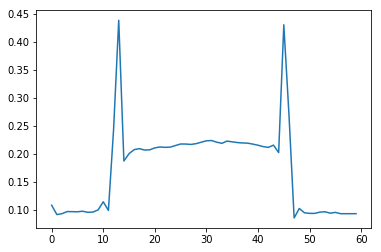

In [9]:
print(idx)
plt.plot(X2[idx].mean(axis=0))
print(X2[idx].mean())
plt.show()

In [10]:
# normalize data, after some trial and error, I arrived to this process
# also clean vertical lines - they are just artifacts from the imaging process
X_train = []
for idx in range(len(X2)):
    x = X2[idx]
    move = x.mean()-0.5*x.std()
    x = np.maximum(x-move,0)
    x = np.minimum(x*3,1)
    cols = x.mean(axis=0)
    mean = x.mean()
    if (mean>0.08):
        for i in range(len(cols)):
            if cols[i]>0.4:
                x[:,i] = 0
        X_train.append(x)
X_train = np.array(X_train)

0.6110926553031495 0.0


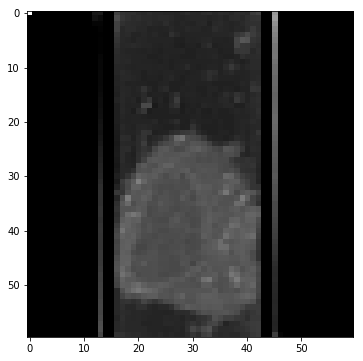

In [11]:
fig,ax = plt.subplots(ncols=1,figsize=(16,6))

# check some images at random
idx = np.random.randint(len(X_train))
x = X_train[idx]
print(x.max(),x.min())
x[0,0]=1
x[0,1]=0

ax.imshow(x,cmap='gray')
plt.show()

5444
0.1155103981114952


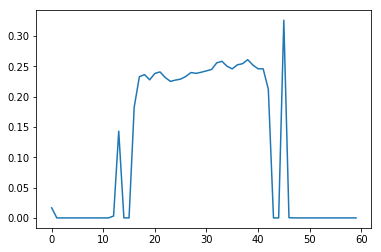

In [12]:
print(idx)
plt.plot(X_train[idx].mean(axis=0))
print(X_train[idx].mean())
plt.show()

In [13]:
X_flat = []
for i in X_train:
    X_flat.append(i.flatten())
X_flat = np.array(X_flat)

In [14]:
from vae import VariationalAutoencoder

In [15]:
X_flat.shape

(5501, 3600)

In [17]:
vae = VariationalAutoencoder(3600,[128,16])

In [22]:
vae.fit(X_flat,10)

Epoch: 1
Cost: -5138674.73046875
Epoch: 2
Cost: -5118805.7265625
Epoch: 3
Cost: -5103740.51953125
Epoch: 4
Cost: -5091080.984375
Epoch: 5
Cost: -5078827.9921875
Epoch: 6
Cost: -5066963.23828125
Epoch: 7
Cost: -5056551.9921875
Epoch: 8
Cost: -5046908.82421875
Epoch: 9
Cost: -5038663.54296875
Epoch: 10
Cost: -5029384.203125


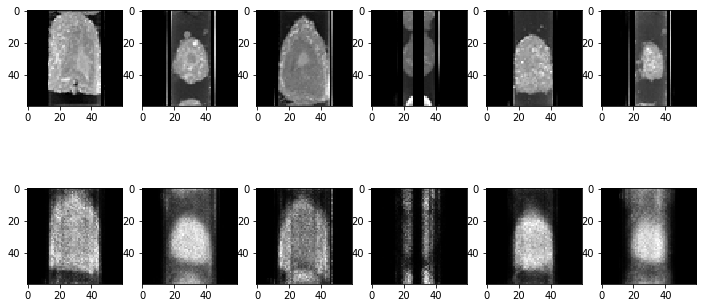

In [23]:
# reconstruct images
fig,ax = plt.subplots(ncols=6,nrows=2,figsize=(12,6))

for i in range(6):
    idx = np.random.randint(len(X_flat))
    ax[0,i].imshow(X_flat[idx].reshape(size,size),cmap='gray')
    ae = vae.predict(X_flat[idx:idx+1])
    ax[1,i].imshow(ae.reshape(size,size),cmap='gray')
plt.show()

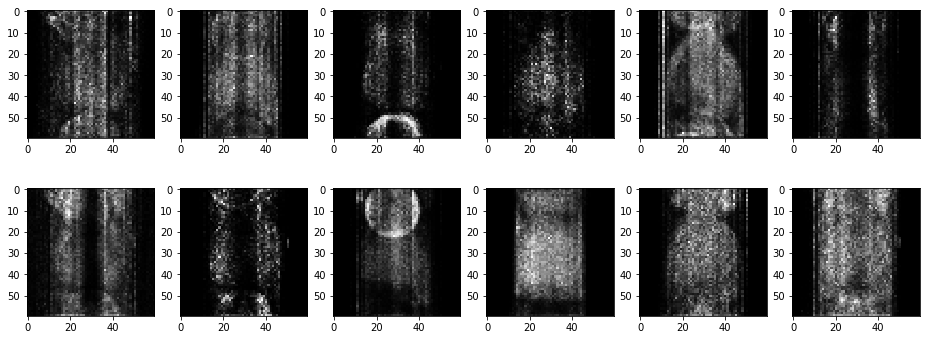

In [24]:
# generate novel images
n = 6
genN = vae.generate(n*2)

fig,ax = plt.subplots(ncols=n,nrows=2,figsize=(16,6))

for i in range(n):
    ax[0,i].imshow((genN[i].reshape(size,size)),cmap='gray')
    ax[1,i].imshow((genN[i+n].reshape(size,size)),cmap='gray')   
plt.show()

In [56]:
from keras import Model
from keras.layers import Input, Dense, Add

In [61]:
input_image = Input(shape=[size**2])
input_Z = Input(shape=[32])

enc = Dense(1024,activation='relu')(input_image)
latent = Dense(32,activation='relu')(enc)
add = Add()([latent,input_Z])
dec = Dense(1024,activation='relu')(add)
output = Dense(size**2,activation='sigmoid')(dec)

model = Model(inputs = [input_image,input_Z],outputs = output)
model.compile(optimizer='adam',loss='binary_crossentropy')

In [78]:
model.fit([X_flat,np.zeros(shape=(len(X_flat),32))],X_flat,batch_size=10,epochs=5)

Epoch 1/5
5501/5501 [==============================] - 71s 13ms/step - loss: 0.2367
Epoch 2/5
5501/5501 [==============================] - 68s 12ms/step - loss: 0.2360
Epoch 3/5
5501/5501 [==============================] - 65s 12ms/step - loss: 0.2354
Epoch 4/5
5501/5501 [==============================] - 64s 12ms/step - loss: 0.2351
Epoch 5/5
5501/5501 [==============================] - 64s 12ms/step - loss: 0.2346


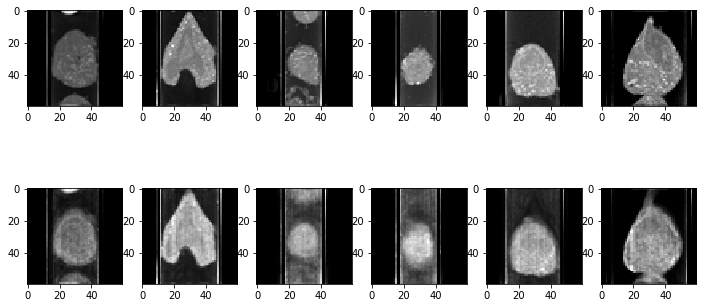

In [79]:
# reconstruct images
fig,ax = plt.subplots(ncols=6,nrows=2,figsize=(12,6))

for i in range(6):
    idx = np.random.randint(len(X_flat))
    ax[0,i].imshow(X_flat[idx].reshape(size,size),cmap='gray')
    ae = model.predict([X_flat[idx:idx+1],np.zeros(shape=[1,32])])
    ax[1,i].imshow(ae.reshape(size,size),cmap='gray')
plt.show()

In [80]:
encoder = Model(inputs=input_image,output=latent)

/opt/intel/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  """Entry point for launching an IPython kernel.


In [81]:
latents = encoder.predict(X_flat)

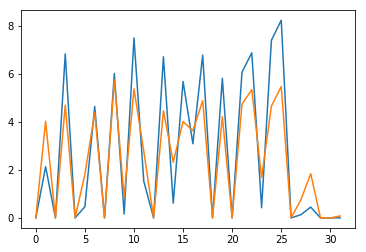

In [82]:
plt.plot(latents.mean(axis=0))
plt.plot(latents.std(axis=0))
plt.show()

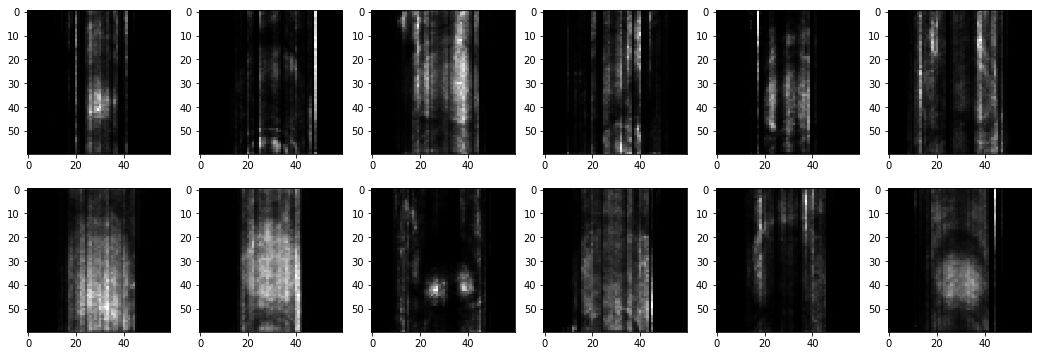

In [93]:
# generate new images
fig,ax = plt.subplots(ncols=6,nrows=2,figsize=(18,6))

Z = np.random.normal(loc=latents.mean(axis=0),scale=latents.std(axis=0),size=(12,32))
novel = model.predict([np.zeros(shape=[len(Z),3600]),Z])

for i in range(6):
    ax[0,i].imshow(novel[i].reshape(size,size),cmap='gray')
    ax[1,i].imshow(novel[i+6].reshape(size,size),cmap='gray')
plt.show()